In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
# sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df_mh = pd.read_csv('전처리/자가점유가구비율_전처리.csv')
df_grdp = pd.read_csv('전처리/GRDP_전처리.csv')
df_er = pd.read_csv('전처리/고용률_전처리.csv')

In [3]:
df_grdp = df_grdp[['연도', '시도', 'GRDP']]

In [4]:
df_mh.columns = ['연도', '시도', '자가점유가구비율']

In [5]:
df_er = df_er[['연도', '시도', '고용률']]

In [6]:
# 먼저 df_mh와 df_grdp 병합
df_merge1 = pd.merge(df_mh, df_grdp, on=['연도', '시도'], how='inner')

# 위 결과를 df_er와 병합
df_final = pd.merge(df_merge1, df_er, on=['연도', '시도'], how='inner')

In [7]:
df_final

,연도,시도,자가점유가구비율,GRDP,고용률
0,2006,전국,55.60,1349602329,60.0
1,2008,전국,56.40,1465186371,59.8
2,2010,전국,54.30,1581956002,58.9
3,2012,전국,53.80,1677574227,59.6
4,2014,전국,53.60,1790169111,60.5
...,...,...,...,...,...
229,2019,제주특별자치도,58.10,22951902,68.4
230,2020,제주특별자치도,58.60,21668785,67.1
231,2021,제주특별자치도,56.60,22346390,67.4
232,2022,제주특별자치도,56.84,23364427,69.9


In [11]:
df_final.iloc[:, 2:].corr()

,자가점유가구비율,GRDP,고용률
자가점유가구비율,1.000000,-0.087031,0.798492
GRDP,-0.087031,1.000000,0.070540
고용률,0.798492,0.070540,1.000000


In [12]:
df_final.groupby(['연도', '시도']).mean()

자가점유가구비율         GRDP   고용률
연도   시도                                  
2006 강원도          57.9   34913848.0  58.3
     경기도          53.2  269977343.0  60.7
     경상남도         62.6   86602805.0  60.8
     경상북도         66.6   84177782.0  63.5
     광주광역시        53.6   29899306.0  55.7
...                ...          ...   ...
2023 전라남도         70.5   85319020.0  66.9
     전라북도         66.4   58845640.0  63.3
     제주특별자치도      57.1   24073959.0  69.2
     충청남도         62.8  134256079.0  64.8
     충청북도         62.0   83254787.0  65.4

[234 rows x 3 columns]

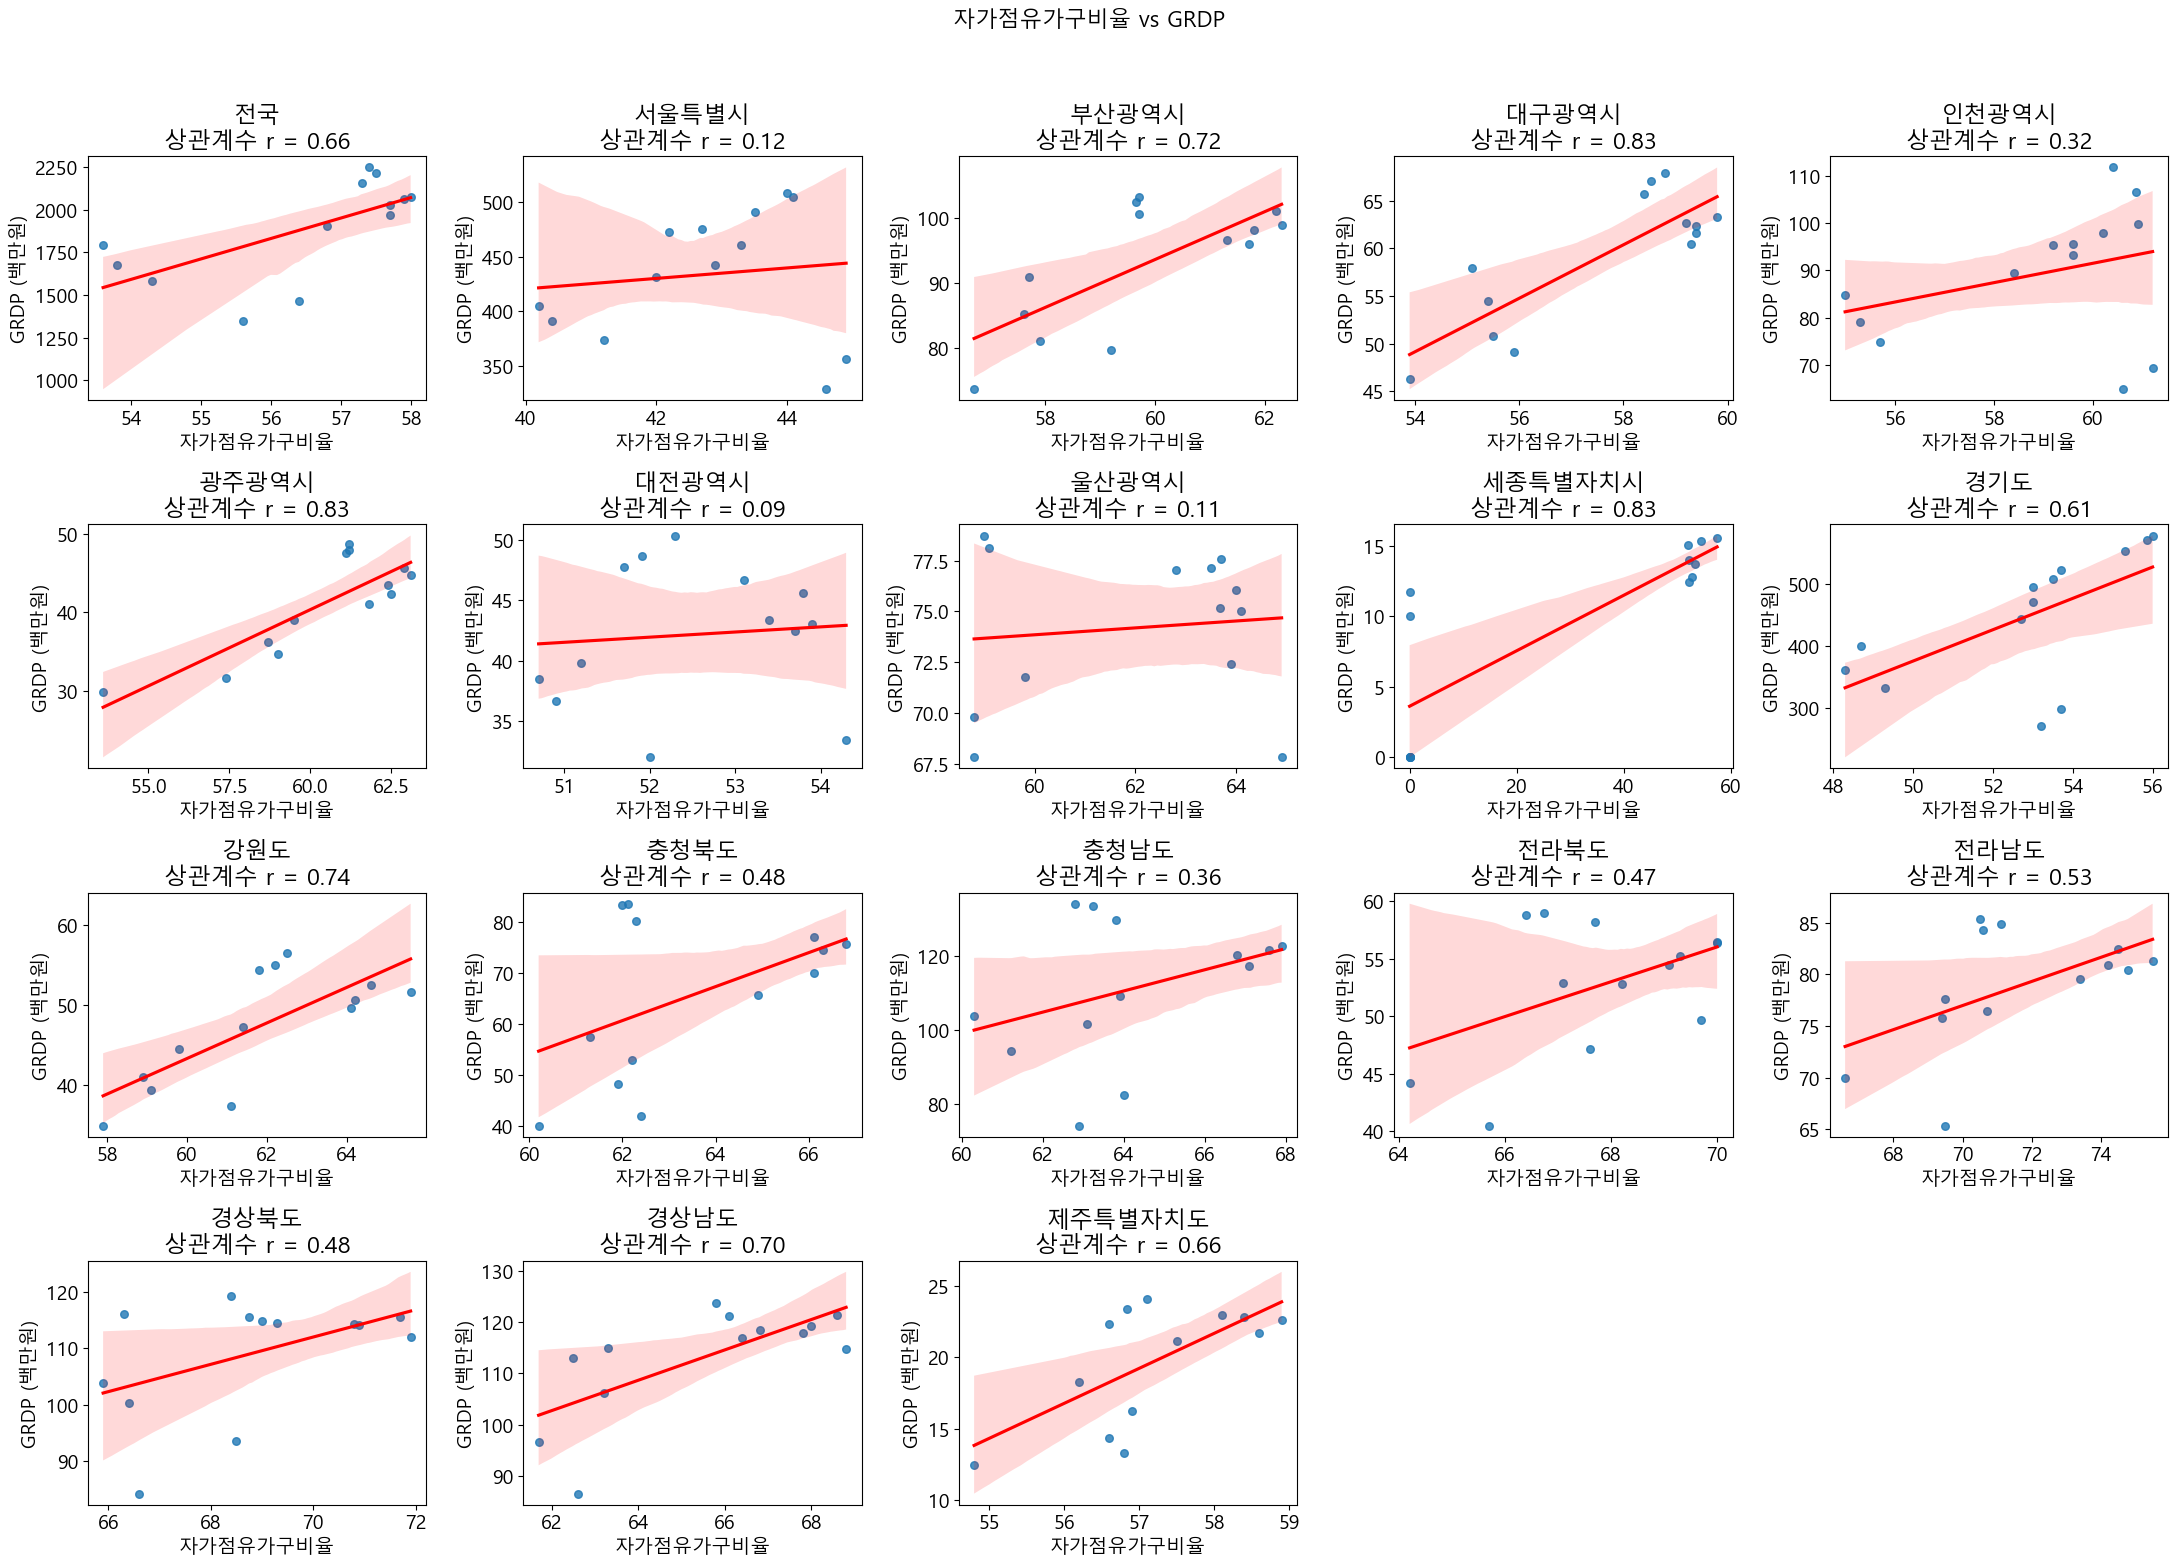

In [20]:
# GRDP 단위 변경
df_final['GRDP_백만'] = df_final['GRDP'] / 1_000_000

# 시도 목록 및 subplot 설정
regions = df_final['시도'].unique()
ncols = 5
nrows = (len(regions) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, nrows * 4))
axes = axes.flatten()

for i, region in enumerate(regions):
    ax = axes[i]
    df_region = df_final[df_final['시도'] == region]

    corr = df_region[['자가점유가구비율', 'GRDP_백만']].corr().iloc[0, 1]

    sns.regplot(data=df_region, x='자가점유가구비율', y='GRDP_백만', ax=ax,
                scatter_kws={'s': 30}, line_kws={'color': 'red'}, ci=95)

    ax.set_title(f'{region}\n상관계수 r = {corr:.2f}')
    ax.set_xlabel('자가점유가구비율')
    ax.set_ylabel('GRDP (백만원)')
    ax.grid(False)
    ax.tick_params(left=True, bottom=True)  # 눈금 표시 추가

# 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('자가점유가구비율 vs GRDP', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### 분석 요약 (1단계: 자가점유가구비율 vs GRDP)
- 일부 지역에서는 자가점유가구비율과 GRDP 사이에 강한 양의 상관관계가 관찰됨
    - (예: 대구, 세종, 광주, 부산, 강원 등 / 상관계수 r ≥ 0.7)

- 그러나 서울, 울산, 대전 등 주요 도시에서는 상관관계가 매우 약하거나 거의 없음
    - 특히 서울은 자가점유율이 낮지만 GRDP는 전국 최고 수준

- 전반적으로 지역 간 일관된 경향성은 없으며, 경제 수준은 주택 소유율 외 다양한 요인의 영향을 받음

### 결론
- 주택 소유율이 높을수록 GRDP가 높다”는 가설은 일부 지역에서만 성립하며, 전국적으로 일반화하기는 어렵다.

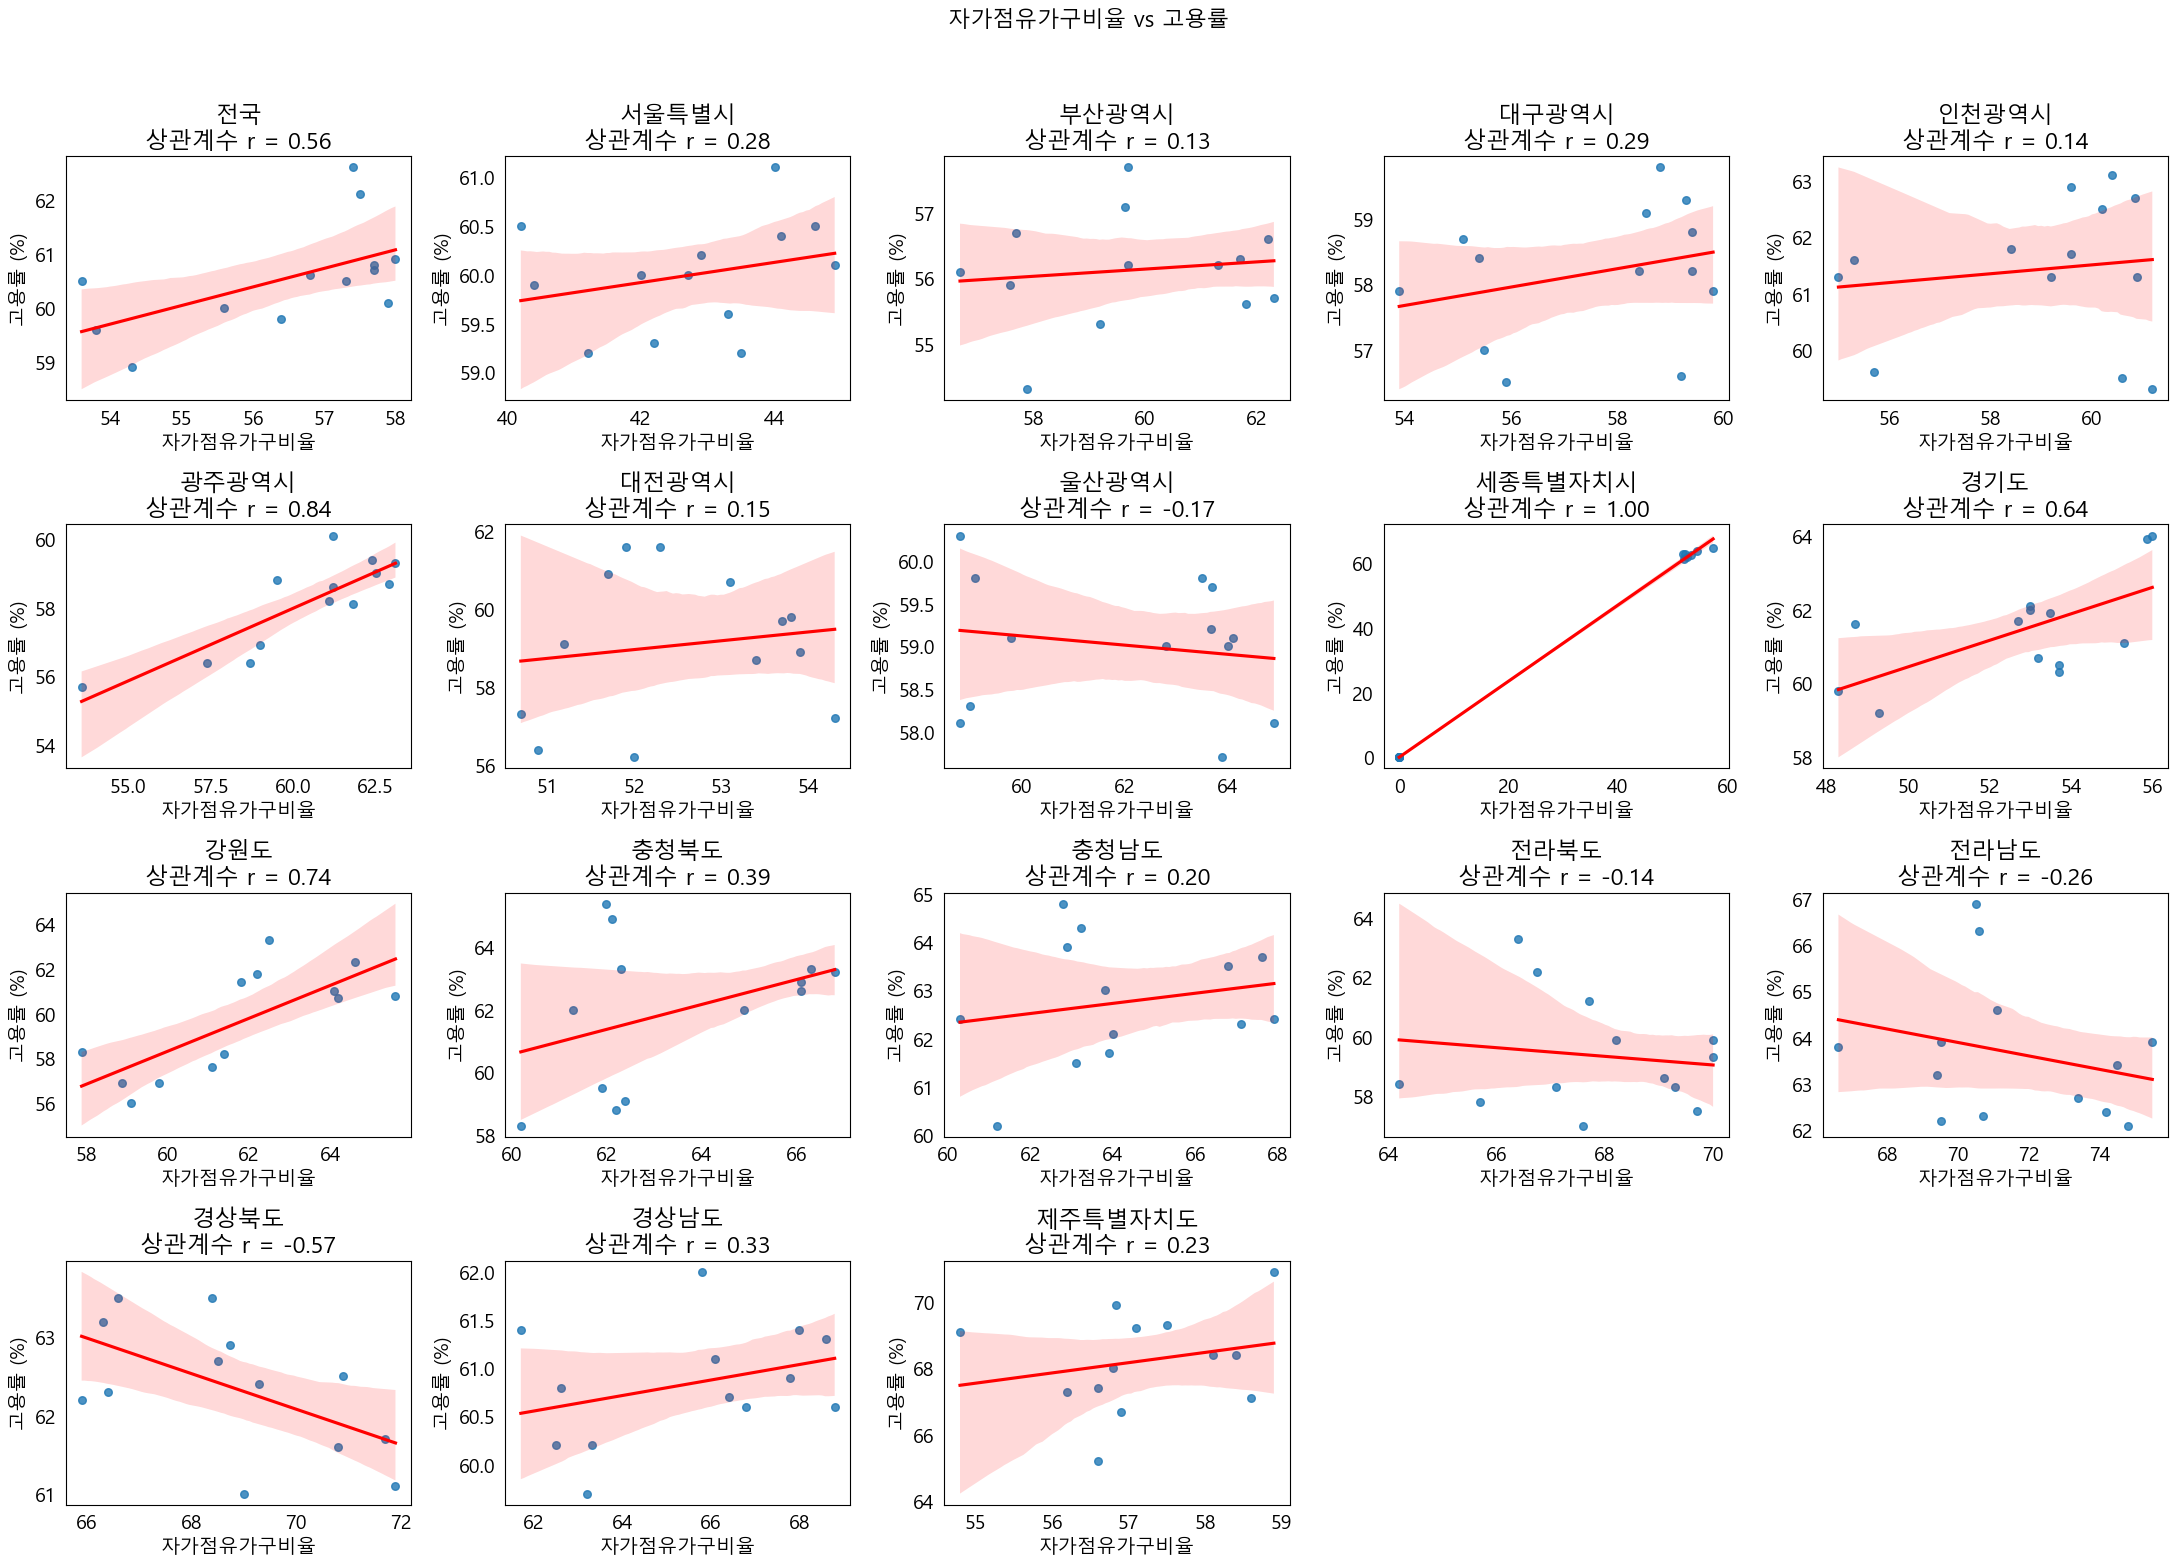

In [16]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, nrows * 4))
axes = axes.flatten()

for i, region in enumerate(regions):
    ax = axes[i]
    df_region = df_final[df_final['시도'] == region]

    # 상관계수
    corr = df_region[['자가점유가구비율', '고용률']].corr().iloc[0, 1]

    sns.regplot(data=df_region, x='자가점유가구비율', y='고용률', ax=ax,
                scatter_kws={'s': 30}, line_kws={'color': 'red'}, ci=95)

    ax.set_title(f'{region}\n상관계수 r = {corr:.2f}')
    ax.set_xlabel('자가점유가구비율')
    ax.set_ylabel('고용률 (%)')
    ax.grid(False)
    ax.tick_params(left=False, bottom=False)

# 남는 subplot 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('자가점유가구비율 vs 고용률', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### 분석 요약 (2단계: 자가점유가구비율 vs 고용률)
- 대다수 지역에서 상관관계가 약하거나 거의 없다.
- 오히려 음의 상관을 보이는 지역도 존재.
- 세종시는 고용률 데이터가 2016년도 부터 공개되었기 때문에 더욱 불분명하다.

### 결론 
- 가설은 일부 지역에서는 제한적으로 지지되지만 전체적으로 성립하지 않는다는 것을 알 수 있다.
- 특히 경제적 안정성이나 고용률은 자가점유율로만 설명하기에 어려움이 있다.

In [22]:
df_final.to_csv('전처리/주택소유율에따른_경제안정성과고용률.csv', index = False)